
<p class="h4 alert alert-danger">
    Please make sure that the pretrained model exists in the path "./models"
</p>


<p class="alert alert-danger">
Also make sure that the BERT server is running and has access to the pretrained model. We can run the BERT server by writing the following command in the command-line:
</p>
<code>> cd [ repo_dir ]/model_training/models</code>
<br />
<code>> bert-serving-start -model_dir ./multi_cased_L-12_H-768_A-12/ -num_worker=1 -show_tokens_to_client</code>


In [120]:
# import required libraries
import pandas as pd
import numpy as np
from pymongo import MongoClient
import bert_serving.client as bert
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



In [121]:
"""
Database loading
"""
# define params for db operations 
uri = 'mongodb://localhost:27017/'
database = 'zs_database'
collection_fetch = 'autotags'
collection_push = 'labels'

# initiate variables
df = pd.DataFrame()
db = object

# connect to db. TODO: Handle exception cases
client = MongoClient(uri)
db = client[database]

# retrieving required data
df = pd.DataFrame(list(db[collection_fetch].find({}, {"_id":0, "lemmas": 1, "story_id": 1, "tokens": 1, "pos": 1, "nouns":1, "entities":1})))

df 

,story_id,tokens,lemmas,pos,nouns,entities
0,19,"[Radio, ÜberAll, sendet, mal, Zukunftsmusik, M...","[Radio, ÜberAll, senden, mal, Zukunftsmusik, M...","[NOUN, PROPN, VERB, ADV, NOUN, SPACE, NOUN, NO...","[Radio ÜberAll, Zukunftsmusik, Mikrofon Krumpe...","[[Radio ÜberAll, MISC], [Mikrofon Krumpel, PER..."
1,21,"[Dorf, pflanzt, SauerstoffMathilda, schaute, m...","[Dorf, pflanzen, SauerstoffMathilda, schauen, ...","[NOUN, VERB, PROPN, VERB, ADJ, NOUN, PROPN, AD...","[Unser Dorf, SauerstoffMathilda, dem Fenster G...","[[SauerstoffMathilda, MISC], [Das Thermometer ..."
2,24,"[langer, lebte, Witwer, einzigen, Tochter, Mut...","[lang, leben, Witwer, einzig, Tochter, Mutter,...","[ADJ, VERB, NOUN, ADJ, NOUN, NOUN, NOUN, VERB,...","[Es, ein Witwer, seiner einzigen Tochter, Die ...","[[Die Mutter des Mädchens, MISC], [warAlles, M..."
3,25,"[Beste, Partys, Buffet, findet, Bernd, steht, ...","[Beste, Party, Buffet, finden, Bernd, stehen, ...","[NOUN, PROPN, NOUN, VERB, PROPN, VERB, NOUN, N...","[Das Beste, Partys, das Buffet, Bernd Ihm, der...","[[Bernd Ihm, PER], [Lea, PER], [Papa, LOC], [W..."
4,27,"[Endlose, Laubwälder, saftige, Weiden, Wildblu...","[Endlose, Laubwälder, saftig, Weide, Wildblume...","[ADJ, NOUN, ADJ, ADJ, NOUN, ADJ, NOUN, VERB, A...","[Endlose Laubwälder, Wildblumenwiesen, wunders...","[[Endlose Laubwälder, PER], [Transsilvanien, L..."
...,...,...,...,...,...,...
195,489,"[Familie, Maus, verläßt, altes, HausErster, Su...","[Familie, Maus, verlassen, alt, HausErster, Su...","[NOUN, PROPN, VERB, ADJ, NOUN, NOUN, NOUN, SPA...","[Familie Maus, ihr gutes altes HausErster Teil...","[[Familie Maus, PER], [HausErster, MISC], [Opa..."
196,490,"[Wolkenland, Glück, einst, Merkmal, Wolkenland...","[Wolkenland, Glück, einen, Merkmal, Wolkenland...","[NOUN, SPACE, NOUN, ADV, NOUN, NOUN, NOUN, ADJ...","[Das Wolkenland Glück, ein Merkmal, des Wolken...","[[Wolkenlandes Doch Sky, MISC], [Wolke, PER], ..."
197,491,"[Tages, wacht, Miro, findet, komplett, Welt, s...","[Tag, wachen, Miro, finden, komplett, Welt, sc...","[NOUN, VERB, PROPN, VERB, ADJ, NOUN, ADJ, VERB...","[Eines Tages, Miro, eine komplett neue Welt, s...","[[Miro, LOC], [Miro, LOC], [Zeit vor dem Umwel..."
198,492,"[Goldene, Sonnenstrahlen, fielen, klare, Wasse...","[Goldene, Sonnenstrahlen, fallen, klaren, Wass...","[ADJ, NOUN, VERB, ADJ, NOUN, VERB, ADJ, NOUN, ...","[Goldene Sonnenstrahlen, die klare Wasseroberf...","[[Goldene Sonnenstrahlen, MISC], [Rhonda, LOC]..."


In [122]:
"""
BERT Embedding
"""
# create bert client
client = bert.BertClient(check_length=False)

# encode token-lemmas from our data into bert-vectors
vectors = client.encode(df['lemmas'].values.tolist(), show_tokens=False, is_tokenized=True)

print(len(vectors))

200


In [123]:
"""
Function: Using TF-IDF to extract key words from a cluster of text
"""

# input: list of string
# output: list of list of keywords 
def keyword(corpus, topK):
    
    key_list = []
    
    # Word frequency matrix 
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus) 
    
    # list of all words in Bag-of-Words model
    word = vectorizer.get_feature_names() 
    
    # TF-IDF Matrix
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X)
    
    # weight[i][j] represents the weight of word j in text i
    weight = tfidf.toarray()
    
    for i in range(len(weight)):
        keys=[]
        zipped = zip(word,weight[i])
        sorted_l=sorted(zipped,key=lambda t:t[1],reverse=True)
        
        for n in range(topK):
            keys.append(sorted_l[n][0])
            
        key_list.append(keys)
    
    return key_list
        

In [184]:
"""
Generate Unwanted words：

So far it's manuel.
TODO：More resources is needed
"""
unwanted=set()
unwanted.add('mensch')
unwanted.add('fragen')
unwanted.add('mal')
unwanted.add('stehen')
unwanted.add('finden')
unwanted.add('hören')
unwanted.add('auge')
unwanted.add('sehen')
unwanted.add('schauen')
unwanted.add('hand')
unwanted.add('')



In [186]:
"""
extract key words for each story : Top 15
"""
frequent_verbs=[]
corpus = []
for i in range(len(df)):
    lemmas_l=[]
    persons=[]
    
    #entitie preprocessing:
    # We want to get rid of all the words which represents the name
    for m in range(len(df['entities'][i])):
        if df['entities'][i][m][1]=='PER':
            persons.append(df['entities'][i][m][0])
    
    # Here we already remove the propn, entity names and verbs
    for j in range(len(df['lemmas'][i])):
        if df['pos'][i][j]!="PROPN" and (df['lemmas'][i][j] not in persons) and (df['lemmas'][i][j].lower() not in unwanted) and df['pos'][i][j]!="VERB"and df['pos'][i][j]!="ADV":
            lemmas_l.append(df['lemmas'][i][j])
    corpus.append(' '.join(lemmas_l))

# it's possible to change the number of feature words here
result = keyword(corpus, 15)

for i in range(len(df)):
    print('Story ID:', df['story_id'][i], result[i])
    

Story ID: 19 ['wolke', 'all', 'bulk', 'zukunftsmusik', 'erde', 'spiegel', 'kohlendioxid', 'luft', 'sonnenschirme', 'co', 'himmel', 'radio', 'ventil', 'forscher', 'einmachglas']
Story ID: 21 ['dorf', 'baum', 'bürgermeister', 'klasse', 'schneien', 'milliarde', 'wettbewerb', 'kohlendioxid', 'pförtner', 'garten', 'rathaus', 'computer', 'auslachen', 'schwitzen', 'umwandeln']
Story ID: 24 ['frosch', 'wolf', 'stiefmutter', 'prinz', 'hexe', 'feige', 'vater', 'könig', 'meinen', 'stiefschwester', 'klimawandel', 'suv', 'bekämpfen', 'weglaufen', 'heimat']
Story ID: 25 ['geist', 'eiszeit', 'wesen', 'schlafzimmer', 'himbeere', 'klima', 'kohle', 'lebensstil', 'wurst', 'teller', 'sehen', 'hand', 'rad', 'heimwerken', 'vorangegangen']
Story ID: 27 ['vampir', 'ratte', 'viola', 'see', 'pilz', 'stall', 'beere', 'burgruine', 'tier', 'wald', 'vater', 'bauch', 'nacht', 'verdutzt', 'transsilvanien']
Story ID: 28 ['schmetterling', 'konsole', 'durchsichtig', 'regenwald', 'kugel', 'klingeln', 'gläsern', 'zeigen',


<p class="h4 alert alert-danger">
    Please make sure to install package wordcloud in the virtual environment
    pip install wordcloud
</p>


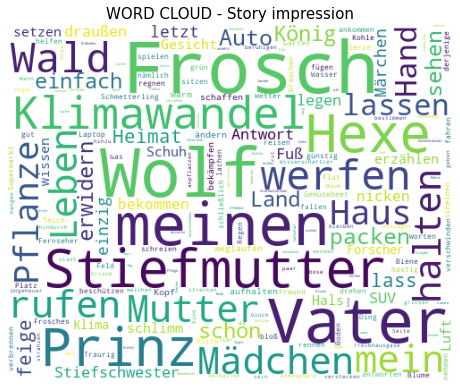

In [170]:
"""
Word Cloud generator
"""

from wordcloud import WordCloud, STOPWORDS
import re
import string
import matplotlib.pyplot as plt


stopwords = unwanted

wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=200,
    max_font_size=80, 
    width=500, height=400,
    random_state=42,
).generate(corpus[2])

print(wordcloud)
fig = plt.figure(figsize = (8,10))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - Story impression",fontsize=15)
plt.axis('off')

plt.show()
wordcloud.to_file('example.jpg')

In [187]:
"""
clustering our vectors using K-means ，show the result of 2 clusters
"""
n_clusters=2
clf = KMeans(n_clusters)
clf.fit(vectors)

#store the centers and label set from our data
centers = clf.cluster_centers_ 
labels = clf.labels_

## FUTURE TODO: We could use the centers to categorize the new input story
print(labels)

[0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1
 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1
 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1
 0 1 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1]


In [193]:
"""
Extract keywords from clusters
"""

cluster_corpus = []

for i in range(n_clusters):
    cluster_corpus.append('')

for i in range(len(labels)):
    cluster_corpus[labels[i]]+=corpus[i]

print(keyword(cluster_corpus, 15))
print("conclusion with human observation:")
print("category1: family")
print("category2: nature")

[['sehen', 'frau', 'mutter', 'vater', 'haus', 'hand', 'erde', 'mein', 'einfach', 'weg', 'schule', 'baum', 'denken', 'luft', 'eltern'], ['sehen', 'hand', 'erde', 'weg', 'baum', 'rufen', 'schauen', 'wasser', 'haus', 'lassen', 'vater', 'weiß', 'leben', 'einfach', 'mein'], ['sehen', 'wald', 'tier', 'kind', 'haus', 'mutter', 'welt', 'wasser', 'frau', 'mein', 'kopf', 'weg', 'hand', 'baum', 'eltern'], ['sehen', 'frau', 'erde', 'vater', 'leben', 'mutter', 'schauen', 'kind', 'hand', 'alt', 'welt', 'schule', 'denken', 'tier', 'haus'], ['sehen', 'leben', 'wasser', 'denken', 'einfach', 'eltern', 'tante', 'welt', 'haus', 'erde', 'hand', 'genau', 'tier', 'alt', 'baum']]
conclusion with human observation:
category1: family
category2: nature


In [194]:
"""
Following are different cluster numbers to find out more potential themes:
"""
n_clusters=3
clf = KMeans(n_clusters)
clf.fit(vectors)

#store the centers and label set from our data
centers = clf.cluster_centers_ 
labels = clf.labels_

# Extract key words for a cluster:
cluster_corpus = []

for i in range(n_clusters):
    cluster_corpus.append('')

for i in range(len(labels)):
    cluster_corpus[labels[i]]+=corpus[i]

print(keyword(cluster_corpus, 15))
print("conclusion with human observation:")
print("category1: familie+environment")
print("category2: leben_love")
print("category3: adventure")

[['sehen', 'erde', 'hand', 'einfach', 'haus', 'mein', 'baum', 'eltern', 'vater', 'rufen', 'denken', 'weg', 'leben', 'wasser', 'kopf'], ['sehen', 'kind', 'tier', 'wald', 'haus', 'hand', 'mutter', 'wasser', 'welt', 'baum', 'kopf', 'weg', 'vater', 'frau', 'mein'], ['sehen', 'frau', 'erde', 'leben', 'vater', 'mutter', 'hand', 'schauen', 'tier', 'welt', 'denken', 'alt', 'kind', 'haus', 'schule']]
conclusion with human observation:
category1: familie+environment
category2: leben_love
category3: adventure


In [195]:
##### Following are different cluster numbers to find out more themes:
n_clusters=4
clf = KMeans(n_clusters)
clf.fit(vectors)

#store the centers and label set from our data
centers = clf.cluster_centers_ 
labels = clf.labels_

# Extract key words for a cluster:
cluster_corpus = []

for i in range(n_clusters):
    cluster_corpus.append('')

for i in range(len(labels)):
    cluster_corpus[labels[i]]+=corpus[i]

print(keyword(cluster_corpus, 15))
# print("conclusion with human observation:")
# print("category1: familie+environment")
# print("category2: leben_love")
# print("category3: adventure")

[['sehen', 'erde', 'frau', 'leben', 'kind', 'mutter', 'hand', 'alt', 'vampir', 'baum', 'denken', 'fahren', 'eltern', 'andrea', 'rufen'], ['sehen', 'baum', 'erde', 'hand', 'weg', 'haus', 'rufen', 'wasser', 'denken', 'einfach', 'lassen', 'schauen', 'vater', 'mein', 'weiß'], ['sehen', 'frau', 'vater', 'tier', 'hand', 'mutter', 'leben', 'haus', 'welt', 'einfach', 'schule', 'schauen', 'denken', 'alt', 'erde'], ['sehen', 'tier', 'kind', 'wald', 'haus', 'welt', 'mutter', 'vater', 'kopf', 'wasser', 'mein', 'eltern', 'hand', 'weg', 'alt']]


In [192]:
##### Following are different cluster numbers to find out more themes:
n_clusters=5
clf = KMeans(n_clusters)
clf.fit(vectors)

#store the centers and label set from our data
centers = clf.cluster_centers_ 
labels = clf.labels_

# Extract key words for a cluster:
cluster_corpus = []

print(labels)
for i in range(n_clusters):
    cluster_corpus.append('')

for i in range(len(labels)):
    cluster_corpus[labels[i]]+=corpus[i]

print(keyword(cluster_corpus, 15))
# print("conclusion with human observation:")
# print("category1: familie+environment")
# print("category2: leben_love")
# print("category3: adventure")

[0 1 3 3 3 1 4 2 3 0 2 1 0 2 2 1 1 2 2 1 2 4 0 2 0 4 4 0 0 0 1 3 1 0 2 0 2
 0 0 3 4 0 1 1 3 1 3 3 2 2 4 3 4 3 0 2 3 0 1 3 1 1 3 3 0 1 1 1 4 3 0 3 4 4
 3 4 1 4 2 0 3 1 1 4 4 0 1 1 1 0 2 2 3 1 3 1 3 3 1 0 3 0 1 2 3 3 2 4 2 2 2
 0 2 2 0 3 1 4 4 1 1 4 0 3 0 1 4 0 3 1 4 0 4 4 4 4 4 1 4 2 0 1 1 1 3 2 1 0
 1 2 1 1 1 4 2 2 0 4 2 2 2 3 0 2 2 2 3 4 3 0 2 3 0 1 1 2 2 1 3 1 0 2 2 3 2
 0 2 1 3 2 2 2 1 3 3 2 3 3 2 3]
[['sehen', 'frau', 'mutter', 'vater', 'haus', 'hand', 'erde', 'mein', 'einfach', 'weg', 'schule', 'baum', 'denken', 'luft', 'eltern'], ['sehen', 'hand', 'erde', 'weg', 'baum', 'rufen', 'schauen', 'wasser', 'haus', 'lassen', 'vater', 'weiß', 'leben', 'einfach', 'mein'], ['sehen', 'wald', 'tier', 'kind', 'haus', 'mutter', 'welt', 'wasser', 'frau', 'mein', 'kopf', 'weg', 'hand', 'baum', 'eltern'], ['sehen', 'frau', 'erde', 'vater', 'leben', 'mutter', 'schauen', 'kind', 'hand', 'alt', 'welt', 'schule', 'denken', 'tier', 'haus'], ['sehen', 'leben', 'wasser', 'denken', 'einfach', 'eltern', 't

In [113]:
##### Following are different cluster numbers to find out more themes:
n_clusters=6
clf = KMeans(n_clusters)
clf.fit(vectors)

#store the centers and label set from our data
centers = clf.cluster_centers_ 
labels = clf.labels_

# Extract key words for a cluster:
cluster_corpus = []

print(labels)
for i in range(n_clusters):
    cluster_corpus.append('')

for i in range(len(labels)):
    cluster_corpus[labels[i]]+=corpus[i]

print(keyword(cluster_corpus, 15))
# print("conclusion with human observation:")
# print("category1: familie+environment")
# print("category2: leben_love")
# print("category3: adventure")

[1 0 3 1 3 2 2 4 5 1 4 0 2 4 4 0 0 2 4 0 4 2 0 4 1 2 2 0 1 1 0 1 2 0 4 1 4
 2 1 5 4 0 0 2 1 0 3 1 4 4 1 3 1 3 0 3 1 1 0 3 2 0 5 1 1 0 0 0 3 5 0 3 2 2
 1 2 2 2 4 2 1 0 0 2 2 1 0 0 4 0 2 3 3 0 1 2 1 1 0 1 5 1 0 4 1 1 4 1 4 3 4
 1 3 4 1 3 2 1 1 0 0 1 1 3 1 0 2 1 1 0 2 4 2 2 2 2 2 4 2 4 1 0 0 0 3 4 0 1
 0 3 0 0 2 2 4 3 4 2 4 4 4 1 1 4 4 3 5 2 5 1 4 1 1 2 0 4 4 0 3 0 0 2 4 5 4
 1 4 0 3 4 4 4 0 3 5 4 3 3 2 5]
[['sehen', 'fragen', 'mal', 'stehen', 'mensch', 'vater', 'auge', 'baum', 'erde', 'weg', 'einfach', 'finden', 'wasser', 'hand', 'haus'], ['mal', 'sehen', 'stehen', 'fragen', 'frau', 'vater', 'mutter', 'auge', 'mensch', 'tier', 'hand', 'schule', 'einfach', 'finden', 'haus'], ['mensch', 'sehen', 'fragen', 'mal', 'stehen', 'leben', 'hören', 'einfach', 'denken', 'rufen', 'auge', 'finden', 'welt', 'haus', 'wasser'], ['sehen', 'fragen', 'mensch', 'mal', 'igel', 'auge', 'leben', 'vampir', 'alt', 'finden', 'tier', 'wald', 'einfach', 'stehen', 'erde'], ['sehen', 'mensch', 'fragen', 'mal', 'stehen